In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
import healpy
from scipy.interpolate import interp1d

import aipy 
import hera_sim
import uvtools
import hera_cal
import linsolve

from pyuvdata import UVBeam, utils
from uvtools.dspec import dayenu_filter, fourier_filter
from uvtools.utils import FFT, fourier_freqs

%matplotlib inline

/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will invo

# Build Observations

Using a 1D array based on a Golomb ruler (https://en.wikipedia.org/wiki/Golomb_ruler).
Frequency coverage (60 to 220 MHz) reflects expanded HERA band.

## Observing Parameters

In [6]:
NFREQS = 1024
NPIX = 128
freqs = np.linspace(.06, .22, NFREQS) # GHz
jds = np.linspace(2458388.0, 2458388.2, 60)

### Antenna Array

In [7]:
# aipy.const.len_ns is the distance light travels in 1 ns (in cm)
# this is roughly 30 cm

# XXX important for long baselines, but unrealistically short?
# this scales all of the antenna positions by ~0.98... but why this value?
sep = 14.7 * 100 / aipy.const.len_ns / 50. # ns

#goloumb = [0, 2, 5, 25, 37, 43, 59, 70, 85, 89, 98, 99, 106]
goloumb = [0,3,15,41,66,95,97,106,142,152,220,221,225,242,295,330,338,354,382,388,402,415,486,504,523,546,553]

# base separation is about 1 meter
seps = {xi-xj: (j,i) for i,xi in enumerate(goloumb) for j,xj in enumerate(goloumb) if xi > xj}

#antpos_dict = hera_sim.antpos.linear_array(20, sep=sep)
antpos_dict = {i: np.array((x * sep, 0., 0.)) for i,x in enumerate(goloumb)}
antpos = np.asarray(list(antpos_dict.values()))

NANTS = antpos.shape[0]
# note that aj > ai for all i, j
baselines = [(aj,ai) for ai in range(NANTS) for aj in range(ai+1,NANTS)]

In [8]:
sep

0.980678439882567

In [9]:
all([antpair in baselines or antpair[::-1] in baselines for antpair in list(seps.values())])

True

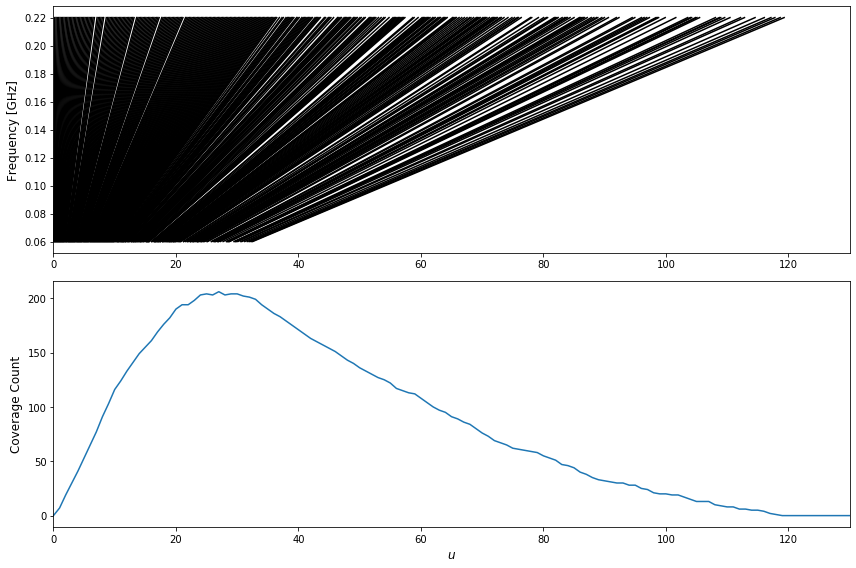

In [10]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2, sharex=ax1)

ax1.set_xlim(0, 130)
ax1.set_ylabel("Frequency [GHz]", fontsize=12)
ax2.set_ylabel("Coverage Count", fontsize=12)
ax2.set_xlabel(r"$u$", fontsize=12)

# initialize an array to keep track of how many baselines sample a
# given u-mode
coverage_vs_u = np.zeros(2000)

for s in seps:
    # get the minimum/maximum u-modes sampled for the given baseline
    umin = s * sep * freqs[0]
    umax = s * sep * freqs[-1]
    
    # update the coverage for given u-mode, assuming all integer u-modes 
    # in (umin, umax) are sampled for the given baseline
    coverage_vs_u[int(np.ceil(umin)):int(np.floor(umax))] += 1
    
    # plot the range of u-modes sampled for the given baseline and
    # range of frequencies
    ax1.plot([umin, umax], [freqs[0], freqs[-1]], color='k')

# now plot the coverage
ax2.plot(coverage_vs_u)

# pretty-up the display
plt.tight_layout()

### Model Beam 

In [11]:
# Option 1: Make a simple Gaussian Beam
def beam_gaussian(xs, fqs, width=0.2, mfreq=0.15, chromatic=True):
    """
    Construct a (possibly chromatic) Gaussian beam.
    
    Parameters
    ----------
    xs : array-like of float
        Sky coordinates to evaluate the beam at, with 0 being at zenith.
        Measured in radians.
        
    fqs : array-like of float
        Frequencies to evaluate the beam at, measured in GHz.
        
    width : float, optional
        FWHM of the beam at the reference frequency, measured in radians.
        Default 0.2 radians.
        
    mfreq : float, optional
        Reference frequency for making a chromatic beam, measured in GHz.
        Default 150 MHz.
        
    chromatic : bool, optional
        Whether to make the beam frequency-dependent. Default True.
        
    Returns
    -------
    response : ndarray of float
        Beam response at the specified sky coordinates and frequencies.
    """
    if np.shape(xs) == ():
        xs = np.array([xs])
    xs.shape = (xs.size,1)
    if np.shape(fqs) == ():
        fqs = np.array([fqs])
    fqs.shape = (1, fqs.size)
    if chromatic:
        width = width * mfreq / fqs
    else:
        width = width * np.ones_like(fqs)
    width.shape = (1,-1)
    resp = np.exp(-(xs**2) / (2 * np.sin(width)**2)).astype(np.float32)
    resp.shape = (xs.size, fqs.size)
    return resp

# Option 2: Sinc function
def beam_sinc(xs, fqs, width=0.2, mfreq=0.15, chromatic=True):
    """
    Create a sinc-function beam response. Same parameters as gaussian_beam.
    """
    if np.shape(xs) == ():
        xs = np.array([xs])
    xs.shape = (xs.size,1)
    if np.shape(fqs) == ():
        fqs = np.array([fqs])
    fqs.shape = (1, fqs.size)
    if chromatic:
        width = width * mfreq / fqs
    else:
        width = width * np.ones_like(fqs)
    width.shape = (1,-1)
    resp = np.sinc(xs / np.sin(width) / 2).astype(np.float32)
    resp.shape = (xs.size, fqs.size)
    return resp    

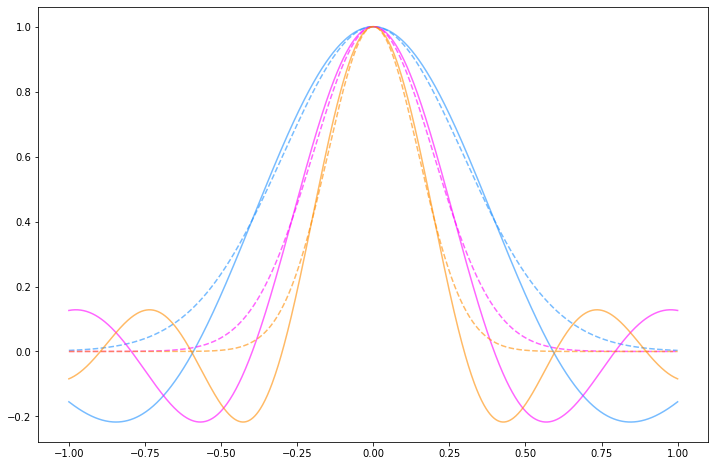

In [12]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)

xs = np.linspace(-1,1,1025,endpoint=True)
for fq, color in zip([.1, .15, .2], ['dodgerblue', 'magenta', 'darkorange']):
    ax.plot(xs, beam_sinc(xs, fq), color=color, ls='-', alpha=0.6)
    ax.plot(xs, beam_gaussian(xs, fq), color=color, ls='--', alpha=0.6)

# Simulate Visibilities (compute intense)

Drawing each pixel of the sky from a uniform distribution, with its own spectral index.

In [13]:
# randomly choose amplitude of the foreground intensity at 150 MHz
# for each pixel on the sky
fg_map = np.random.uniform(0, 10, size=(NPIX,1))

# randomly choose a spectral index for each pixel
fg_ind = np.random.uniform(-2, -1, size=(NPIX,1))

# make a chromatic/achromatic foreground intensity map
Isky = {
    'F': fg_map * (freqs/0.15)**fg_ind, # chromatic
    'f': fg_map * (0.150/0.15)**fg_ind, # achromatic
}

# make the sky coordinates
xs = np.linspace(-1, 1, NPIX, endpoint=True)
dx = np.median(np.diff(xs))

In [14]:
# mock up EoR intensities
Isky['E'] = np.random.uniform(0, .0001, size=(NPIX,NFREQS))

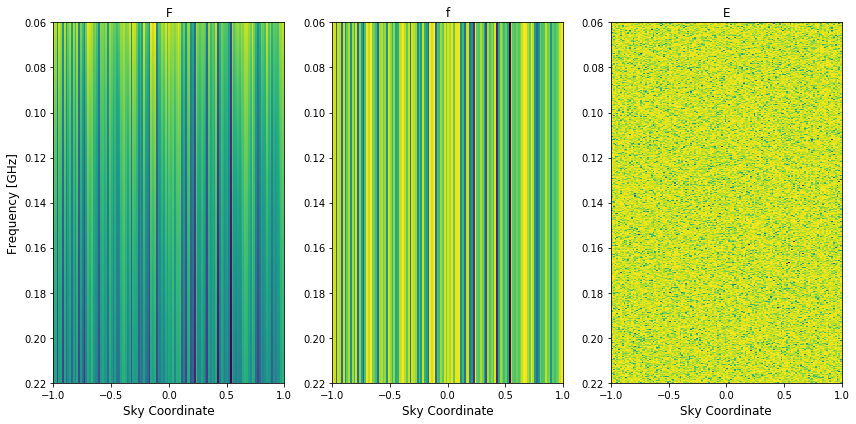

In [15]:
fig = plt.figure(figsize=(12,6))
axes = fig.subplots(1,3)
axes.ravel()[0].set_ylabel("Frequency [GHz]", fontsize=12)

freqs = freqs.flatten()
extent = (-1,1,freqs[-1],freqs[0])

for ax, key in zip(axes.ravel(), Isky):
    ax.set_title(key)
    ax.set_xlabel("Sky Coordinate", fontsize=12)
    fig.sca(ax)
    uvtools.plot.waterfall(Isky[key].T, extent=extent)

plt.tight_layout()

### An Aside About Integrating Fringes

To accommodate a sparsely sampled sky, we need to be careful about aliasing our fringe. Each sample of the fringe should be regarded as the integral of the fringe function over the width of the sky pixel.
\begin{equation}
f(x_0) = \frac{1}{\Delta x}\int_{x_0-\Delta x/2}^{x_0+\Delta x/2}{f(x) dx}
\end{equation}

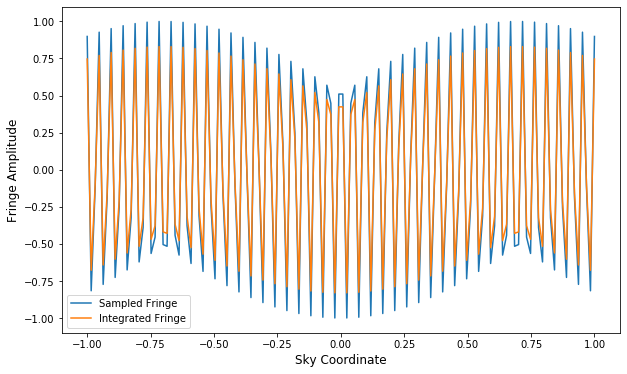

In [16]:
# choose some frequency
fq = freqs.flatten()[-1]

# choose some baseline
bl = antpos[0] - antpos[6]

# sample the fringe at all sky coordinates for the given frequency/baseline
fringe = np.exp(-2j*np.pi*xs*bl[0]*fq)

# evaluate the fringe at the pixel edges
fringe_1 = np.exp(-2j*np.pi*(xs+dx/2)*bl[0]*fq)
fringe_2 = np.exp(-2j*np.pi*(xs-dx/2)*bl[0]*fq)

# analytic integration of the fringe
int_fringe = 1./(-2j*np.pi*bl[0]*fq) * (fringe_1 - fringe_2) / dx

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_xlabel('Sky Coordinate', fontsize=12)
ax.set_ylabel('Fringe Amplitude', fontsize=12)

ax.plot(xs.flatten(), fringe.flatten().real, label='Sampled Fringe')
ax.plot(xs.flatten(), int_fringe.flatten().real, label='Integrated Fringe')

ax.legend(loc='best')

In [17]:
# construct chromatic and achromatic beams
bm = {
    'G': beam_gaussian(xs, freqs, chromatic=True),
    'g': beam_gaussian(xs, freqs, chromatic=False),
    'S': beam_sinc(xs, freqs, chromatic=True),
    's': beam_sinc(xs, freqs, chromatic=False),
}

# initialize a dictionary for storing visibilities
vis = {}
for bm_key in bm.keys():
    for sky_key in Isky.keys():
        vis[bm_key + sky_key] = np.empty((NFREQS, NANTS, NANTS), dtype=np.complex64)

for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    # Integrate fringe pattern to avoid aliasing for a sparsely sampled sky
    #fringe = np.exp(-2j*np.pi*xs*bl[0]*freqs) # took integral of this over a pixel
    fringe_1 = np.exp(-2j*np.pi*(xs+dx/2)*blx*freqs)
    fringe_2 = np.exp(-2j*np.pi*(xs-dx/2)*blx*freqs)
    fringe = 1./(-2j*np.pi*blx*freqs*dx) * (fringe_1 - fringe_2) / dx
    for k,v in vis.items():
        # XXX deal with this problem
        v[:,ai,aj] = np.sum(bm[k[0]]**2 * fringe * Isky[k[1]], axis=0)
#        v[:,ai,aj] = np.sum(bm[k[0]] * fringe * Isky[k[1]], axis=0)
        v[:,aj,ai] = v[:,ai,aj].conj()

## Visibility spectra from multiple baselines, plotted versus $u$

/home/bobby/anaconda3/envs/hera/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


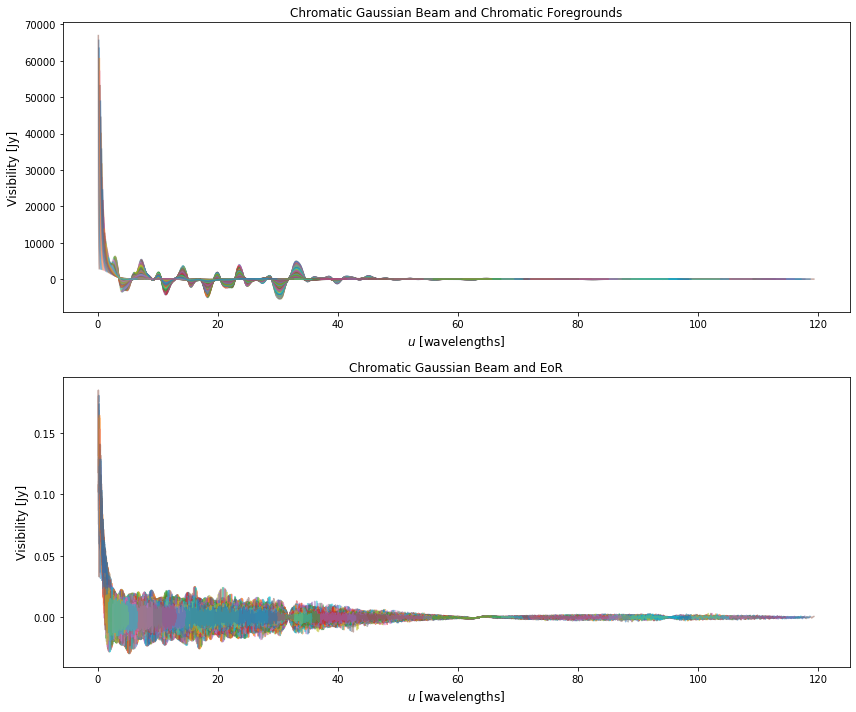

In [18]:
fqs = freqs.flatten()

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.set_title("Chromatic Gaussian Beam and Chromatic Foregrounds", fontsize=12)
ax2.set_title("Chromatic Gaussian Beam and EoR", fontsize=12)

for ax in (ax1, ax2):
    ax.set_xlabel(r"$u$ [wavelengths]", fontsize=12)
    ax.set_ylabel("Visibility [Jy]", fontsize=12)
    
for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    us = blx * fqs
    ax1.plot(us, vis['GF'][:,ai,aj], alpha=0.5)

for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    us = blx * fqs
    ax2.plot(us, vis['GE'][:,ai,aj], alpha=0.5)
    
plt.tight_layout()

## Interpolating visibilities to a fixed $u$

### Simulate visibilities on a fixed grid in $u$

In [19]:
u = 30
# Determine true visibility
# Integrate fringe pattern to avoid aliasing for a sparsely sampled sky
fringe_1 = np.exp(-2j*np.pi*(xs+dx/2)*u)
fringe_2 = np.exp(-2j*np.pi*(xs-dx/2)*u)
fringe = 1./(-2j*np.pi*u*dx) * (fringe_1 - fringe_2) / dx

# Simulate visibilites exactly at the specified $u$
# the values in V_u are exactly the visibilities for each frequency
# at the specified u-mode
#V_u = {k: np.sum(bm[k[0]] * fringe * Isky[k[1]], axis=0) for k in vis.keys()}
V_u = {k: np.sum(bm[k[0]]**2 * fringe * Isky[k[1]], axis=0) for k in vis.keys()}
true_cubic = {k: interp1d(freqs.flatten(), v, kind='cubic', assume_sorted=True) for k,v in V_u.items()}

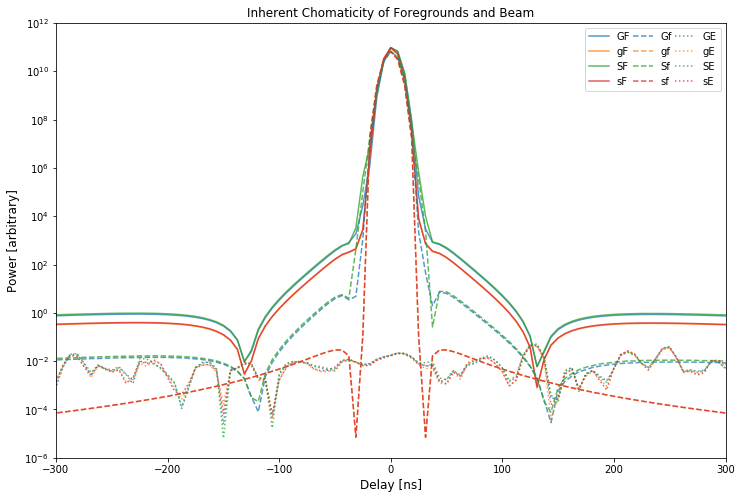

In [20]:
# generate a blackman-harris window
window = aipy.dsp.gen_window(freqs.size, 'blackman-harris')
# get the delays appropriate for the simulation
tau = np.fft.fftfreq(freqs.size, np.median(np.diff(freqs.flatten())))

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlim(-300,300)
ax.set_ylim(1e-6, 1e12)
ax.set_title('Inherent Chomaticity of Foregrounds and Beam', fontsize=12)
ax.set_xlabel('Delay [ns]', fontsize=12)
ax.set_ylabel('Power [arbitrary]', fontsize=12)

# loop over all intensity maps
for fg_type, linestyle in zip('FfE',('-','--',':')):
    # loop over all beam types
    for bm_type in 'GgSs':
        # get the key for the visibility data
        k = bm_type + fg_type
        
        # take the windowed FFT of the data
        dat = window * V_u[k].flatten()
        _dat = np.abs(np.fft.fft(dat))**2
        
        ax.semilogy(np.fft.fftshift(tau), np.fft.fftshift(_dat), 
                    ls=linestyle, label=k, alpha=0.75)
    for i in range(6): ax._get_lines.get_next_color()

ax.legend(ncol=3, columnspacing=.25, fontsize=10)

### Filter true visibilities

In [21]:
# choose some necessary parameters for doing a linear filter

# half-width of filter in ns
filter_widths = [10., 20., 40., 80., 160.]

# uniform weighting
wgts = np.ones_like(freqs.flatten())

# channel width in GHz
df = np.median(np.diff(freqs.flatten()))

# generate some noise
noise = np.random.normal(loc=0, scale=1e-5, size=freqs.size)

# choose to center the delay filter at 0 s, scale the filter by 1e9, and
# filter over the frequency axis (although this is the *only* axis, and the
# code in linear_filter doesn't care what it is for a 1d array)
kwargs = {'filter_centers':[0.], 'filter_factors':[1e-9], 'filter_dimensions':[1]}

# initialize a dictionary for storing the filtered visibilities
V_uf = {}

# loop over the entries in the visibility dict for the u=30 mode
# recall that the keys specify which beam type is used and which type of
# emission is simulated; lower-case -> achromatic
for k in V_u.keys():
    for w in filter_widths:
        # update the parameters with the filter half width
        kwargs['filter_half_widths'] = [w]
        # filter the visibility itself
        V_uf[k+'_',w], info = dayenu_filter(fqs, V_u[k], wgts, **kwargs)
        # filter the visibility with some noise added
        V_uf[k+'N',w], info = dayenu_filter(fqs, V_u[k] + noise, wgts, **kwargs)
        # filter the visibility with EoR added
        V_uf[k+'E',w], info = dayenu_filter(fqs, V_u[k] + V_u[k[0]+'E'], wgts, **kwargs)

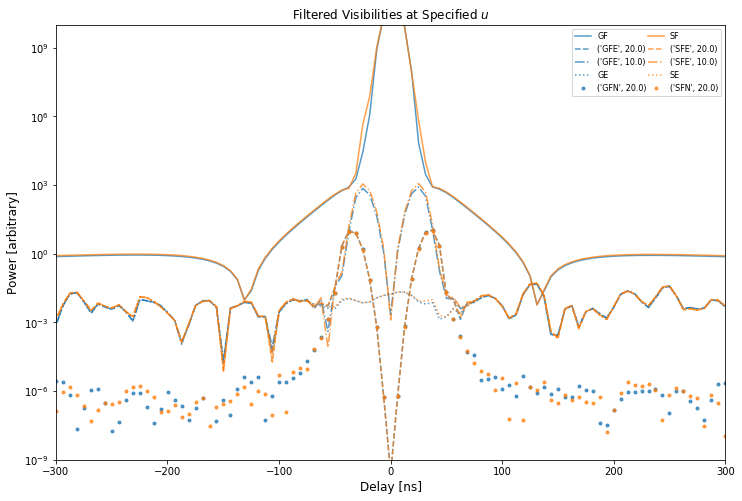

In [22]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlim(-300,300)
ax.set_ylim(1e-9, 1e10)
ax.set_title(r'Filtered Visibilities at Specified $u$', fontsize=12)
ax.set_xlabel('Delay [ns]', fontsize=12)
ax.set_ylabel('Power [arbitrary]', fontsize=12)


#window = aipy.dsp.gen_window(freqs.size, 'blackman-harris')
#tau = np.fft.fftfreq(freqs.size, np.median(np.diff(freqs.flatten())))

# only plot filtered visibilities for chromatic beams
for k in 'GS':
    # only choose chromatic foregrounds (+ something) or just EoR
    # remember that the number is the filter half width in ns
    keys = (k+'F', (k+'FE',20.), (k+'FE',10.), k+'E', (k+'FN',20.))
    lines = ('-','--','-.',':', '.')
    for k,lin in zip(keys,lines):
        # choose either the unfiltered or filtered vis
        # based on whether the key is a string or tuple
        if type(k) is str: dat = V_u[k]
        else: dat = V_uf[k]
        
        # look at the windowed autocorrelation of the visibility
        dat = window * dat.flatten()
        _dat = np.abs(np.fft.fft(dat))**2
        ax.semilogy(np.fft.fftshift(tau), np.fft.fftshift(_dat), lin, label=k, alpha=0.75)
        # not sure why this implementation was used, but it works
        for i in range(9): ax._get_lines.get_next_color()
    ax._get_lines.get_next_color()

plt.legend(ncol=2, columnspacing=.1, fontsize=8)

The plot above seems to indicate that, if we had access to measurements of a given $u$ mode for all frequencies, we would be able to contain the foregrounds to low delay modes, even when we include the chromaticity of the the beam.

### Interpolate data to specified $u$

Now we need to see if we can get similar results interpolating chromatic visibilities to
a given $u$ from the visibilities handed us by an array.

In [23]:
# get the frequency resolution and ensure the
# frequencies used are a 1d array
FQ_RES = np.median(np.diff(freqs))
fqs = freqs.flatten()

# make a nested dictionary to compare different types of
# interpolation over u-modes
_V_u = {'lin':{}, 'cub':{}}

# recall that vis is a dictionary of (NFREQS, NANTS, NANTS) shaped
# ndarrays containing visibilities measured by the sample antenna array
# the keys of vis give the beam type and intensity type
for bm_fg, v in vis.items():
    # use a nested structure for the interpolated visibilities, with
    # the following order: 
    # interpolation type -> visibility identifier -> (freq, ant1, ant2)
    for interp in _V_u.keys():
        _V_u[interp][bm_fg] = {}
    # loop over all baselines
    for ai,aj in baselines:
        # unpack the baseline components
        blx,bly,blz = bl = antpos[ai] - antpos[aj]
        
        # find out which frequency corresponds to u=30
        fq = u / blx # interpolate to u set above
        
        # don't do anything if the frequency is outside the observed freqs
        if fq < fqs[0] or fq > fqs[-1]: continue
        
        # index interpolated vis entries by required frequency and baseline
        key = (fq, ai, aj)
        
        # make a cubic spline interpolation object and evaluate it at the
        # required frequency for the desired u-mode and given EW baseline length
        vis_interp = interp1d(fqs, vis[bm_fg][:,ai,aj], kind='cubic', assume_sorted=True)
        _V_u['cub'][bm_fg][key] = vis_interp(fq)
        
        # find out which channels the required frequency resides between
        fq_px0 = np.floor((fq - fqs[0]) / FQ_RES).astype(np.int)
        fq_px1 = fq_px0 + 1
        
        # find out where in the channel the required frequency is
        d = (fq - fqs[0]) / FQ_RES - fq_px0
        
        # get the visibility at that frequency assuming a linear change
        # over the given channel
        _V_u['lin'][bm_fg][key] = (1-d) * vis[bm_fg][fq_px0,ai,aj] + d * vis[bm_fg][fq_px1,ai,aj]

# get all of the (fq, ant1, ant2) used and sort them by frequency
keys = sorted(list(_V_u['lin'].values())[0].keys())

# get the frequencies that correspond to the desired u-mode
vis_u_freqs = np.array([k[0] for k in keys])

# get the interpolated visibilities as a function of frequency
vis_u = {}
for interp in _V_u.keys():
    vis_u[interp] = {
        bm_fg : [v[k] for k in keys] 
        for bm_fg, v in _V_u[interp].items()
    }

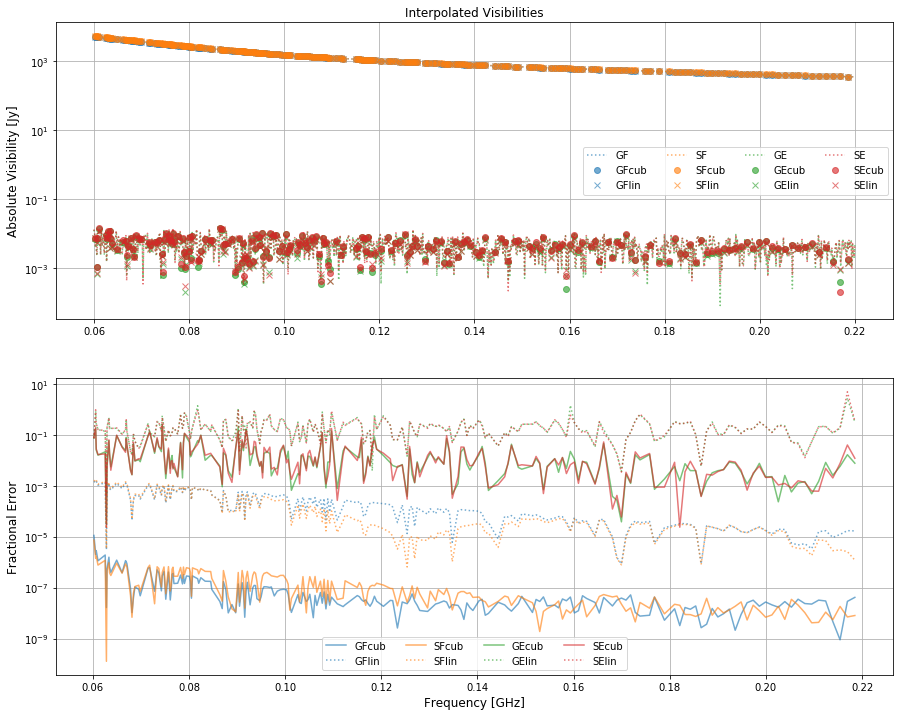

In [24]:
vis_types = ("GF", "SF", "GE", "SE")
colors = ("darkred", "darkorange", "magenta", "cyan")
alpha = 0.625
def cycle_colors(ax):
    for i in range(9): ax._get_lines.get_next_color()

fig = plt.figure(figsize=(15,12))

ax1 = fig.add_subplot(211)
ax1.set_ylabel("Absolute Visibility [Jy]", fontsize=12)
ax1.set_title("Interpolated Visibilities", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.set_xlabel("Frequency [GHz]", fontsize=12)
ax2.set_ylabel("Fractional Error", fontsize=12)

for k, color in zip(vis_types, colors):
    Vtrue = true_cubic[k](vis_u_freqs)
    
    ax1.semilogy(fqs, np.abs(true_cubic[k](fqs)), 
                 ls=':', label=k, alpha=alpha)
    cycle_colors(ax1)
    ax1.semilogy(vis_u_freqs, np.abs(vis_u['cub'][k]), 
                 marker='o', lw=0, label=k+'cub', alpha=alpha)
    cycle_colors(ax1)
    ax1.semilogy(vis_u_freqs, np.abs(vis_u['lin'][k]), 
                 marker='x', lw=0, label=k+'lin', alpha=alpha)
        
    ax2.semilogy(vis_u_freqs, np.abs(vis_u['cub'][k]/Vtrue - 1), 
                 ls='-', label=k+'cub', alpha=alpha)
    cycle_colors(ax2)
    ax2.semilogy(vis_u_freqs, np.abs(vis_u['lin'][k]/Vtrue - 1), 
                 ls=':', label=k+'lin', alpha=alpha)

for ax in (ax1, ax2):
    ax.grid()
    _ = ax.legend(ncol=4)

The above plots show that it is possible to interpolate the sampled data of a (noiseless) baseline to the frequency corresponding to a particular $u$ mode with reasonable accuracy.  Linear interpolation has error associated with it which is mitigated with cubic interpolation.  If we need better interpolation, the delay basis would be a good candidate for further improvement, but to accurately reproduce EoR modes, it will need to include high delays.

### Filter interpolated samples

In [25]:
# use uniform weights
wgts_u = np.ones_like(vis_u_freqs.flatten())

# generate some noise
noise_u = np.random.normal(loc=0, scale=1e-6, size=vis_u_freqs.size)

df_u = 1.
kwargs = {'filter_centers':[0.], 'filter_factors':[1e-9],
          'filter_dimensions':[1], }

# user_frequencies parameter is now replaced by the required parameter x
# which is the independent variable for the axis to be filtered along

vis_uf = {}
for interp in vis_u.keys():
    vis_uf[interp] = {}
    for k,v in vis_u[interp].items():
        v = np.array(v)
        for w in filter_widths:
            cache = {}
            kwargs['cache'] = cache
            kwargs['filter_half_widths'] = [w]
            # filter the interpolated foregrounds
            vis_uf[interp][k+'_',w], info = dayenu_filter(
                vis_u_freqs, v, wgts_u, **kwargs
            )
            # filter the interpolated foregrounds + noise
            vis_uf[interp][k+'N',w], info = dayenu_filter(
                vis_u_freqs, v + noise_u, wgts_u, **kwargs
            )
            # filter the interpolated foregrounds + EoR
            vis_uf[interp][k+'E',w], info = dayenu_filter(
                vis_u_freqs, v + vis_u[interp][k[0]+'E'], wgts_u, **kwargs
            )

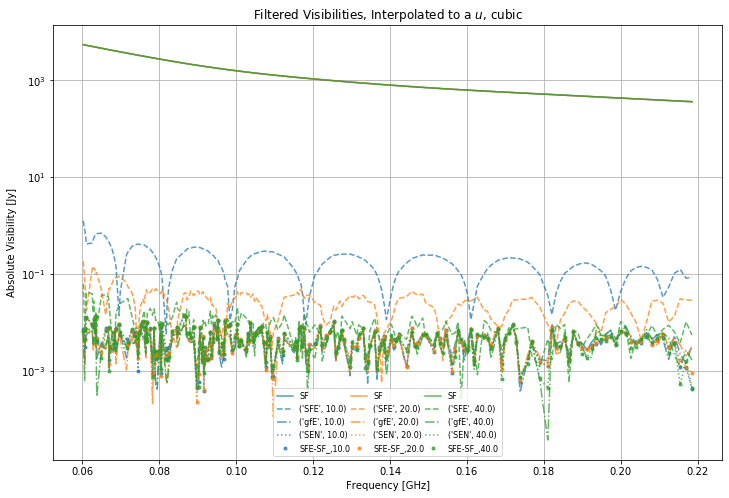

In [26]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Filtered Visibilities, Interpolated to a $u$, cubic')
ax.set_xlabel('Frequency [GHz]')
ax.set_ylabel('Absolute Visibility [Jy]')

ax.grid()
for w in (10., 20., 40.):
    keys = ('SF', ('SFE',w), ('gfE',w), ('SEN',w))
    lines = ('-','--','-.',':', '.')
    for k,lin in zip(keys,lines):
        if type(k) is str: dat = vis_u['cub'][k]
        else: dat = vis_uf['cub'][k]
        ax.semilogy(vis_u_freqs, np.abs(dat), lin, label=k, alpha=0.75)
        for i in range(9): ax._get_lines.get_next_color()
    ax.semilogy(vis_u_freqs, np.abs(vis_uf['cub']['SFE',w] - vis_uf['cub']['SF_',w]), 
                 '.', label='SFE-SF_,'+str(w), alpha=0.75)
    #ax._get_lines.get_next_color()
_ = ax.legend(ncol=3, columnspacing=.1, fontsize=8)


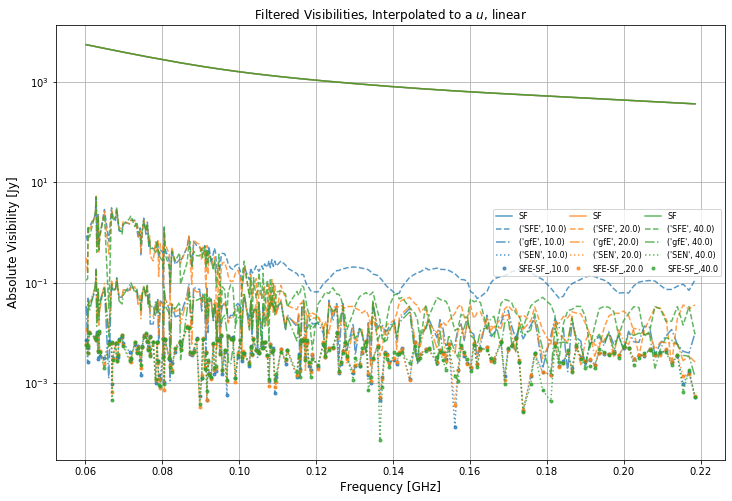

In [27]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_title('Filtered Visibilities, Interpolated to a $u$, linear', fontsize=12)
ax.set_xlabel('Frequency [GHz]', fontsize=12)
ax.set_ylabel('Absolute Visibility [Jy]', fontsize=12)
ax.grid()

for w in (10., 20., 40.):
    keys = ('SF', ('SFE',w), ('gfE',w), ('SEN',w))
    lines = ('-','--','-.',':', '.')
    for k,lin in zip(keys,lines):
        if type(k) is str: dat = vis_u['lin'][k]
        else: dat = vis_uf['lin'][k]
        ax.semilogy(vis_u_freqs, np.abs(dat), lin, label=k, alpha=0.75)
        cycle_colors(ax)
    ax.semilogy(vis_u_freqs, np.abs(vis_uf['lin']['SFE',w] - vis_uf['lin']['SF_',w]), 
                '.', label='SFE-SF_,'+str(w), alpha=0.75)
    #ax._get_lines.get_next_color()

_ = ax.legend(ncol=3, columnspacing=.1, fontsize=8)

The above plots illustrate that for sufficiently smooth foregrounds/beams (e.g. achromatic, gaussian = gfE), foregrounds can be filtered out to recover the EoR signal.  However, if the array sampling is too sparse (at higher frequencies, for example), these filters kill a lot of EoR signal. Worst case, they throw out as much foreground as EoR and the signal is inaccessible by filtering, although it may be recovered by subtracting off foregrounds.

In order to be able to effectively separate foregrounds from EoR, the array must deliver a certain density of sampling.  Inasmuch as foreground amplitude controls the amplitude of the residual, interpolation matters, but it is probably not the primary effect.

# Using Redundancy in $u$ to subtract foregrounds in baselines

In [28]:
def get_u_bounds(coverage, cov_thresh):
    """
    Determine min/max u values such that every u in [umin, umax] 
    has at least the number of baseline samples given by cov_thresh.
    
    Parameters
    ----------
    coverage : array-like
        Histogram counting number of samples as a function of u.
        Assumes that the coverage is indexed by u.
        
    cov_thresh : int
        Minimum number of baselines that sample the given u.
        
    Returns
    -------
    umin, umax : tuple of int
        Lower and upper bounds of region in which u-modes are all sampled
        at least ``cov_thresh`` times.
    """
    coverage = np.asarray(coverage)
    dense_cov = np.argwhere(coverage > cov_thresh).flatten()
    return dense_cov[0], dense_cov[-1]

In [29]:
def convert_u_to_bl_len(u, freq):
    """
    Convert u at a given frequency to a baseline length in meters.
    
    Parameters
    ----------
    u : float
        u-mode for which to determine the baseline length.
        
    freq : float
        Frequency at which to determine the baseline length for the
        given u. Units of GHz.
        
    Returns
    -------
    bl_len : float
        Length of the baseline measuring the given u-mode at the specified
        frequency. Units of meters.
    """
    wavelength = aipy.const.c / (freq * 1e9) / 100 # meters
    return u * wavelength

In [30]:
def get_good_channels(bl_ns, freqs, umin, umax, return_freqs=False):
    """
    For a given EW baseline, find the frequency channels that correspond 
    to u-modes within the specified range (umin, umax).
    
    Parameters
    ----------
    bl_ns : float
        Length of the east-west component of the baseline in units of ns.
        
    freqs : array-like of float
        Frequency array in units of GHz.
        
    umin : float
        Minimum bound for the u-modes of interest.
        
    umax : float
        Maximum bound for the u-modes of interest.
        
    return_freqs : bool, optional
        Whether to return the frequency channels or the subset of frequencies
        themselves. Default is to return the frequency channels.
        
    Returns
    -------
    chans : array-like of int
        Channels corresponding to frequencies that probe the desired u-modes.
        If ``return_freqs`` is set to True, then this is the actual subarray 
        of frequencies, in units of GHz.
    """
    try:
        bl_ns = bl_ns[0]
    except (TypeError, IndexError):
        pass
    freqs = np.asarray(freqs).flatten()
    uvals = bl_ns * freqs
    chans = np.argwhere(np.logical_and(umin < uvals, umax > uvals)).flatten()
    if return_freqs:
        chans = freqs[chans]
    return chans

In [31]:
def construct_vis_dict(ant1, ant2, antpos, freqs, 
                       coverage, cov_thresh=None,
                       umin=None, umax=None, 
                       show_progress=False,
                       **kwargs):
    """
    Do all the things.
    
    Parameters
    ----------
    ant1, ant2 : int
        Antennas specifying which baseline to construct the visibility dictionary 
        for.
        
    antpos : dict
        Dictionary whose keys are antenna numbers and whose values are the 
        corresponding positions for each antenna.
        
    freqs : array-like of float
        Frequencies for which the true visibilities are evaluated. Should be 
        in units of GHz.
        
    coverage : array-like of int
        Array whose entries count the number of baselines that sample the u-mode 
        corresponding to the index of the entry.
        
    cov_thresh : int
        If provided, specifies the minimum number of times a u-mode must be sampled 
        to be included when constructing the interpolated visibilities--this sets 
        the parameters ``umin`` and ``umax``. If not specified, then both ``umin`` 
        and ``umax`` must be specified.
        
    umin, umax : int
        Lower- and upper-bounds of u-modes to include when constructing the 
        interpolated visibilities. If not provided, then ``cov_thresh`` must be 
        provided. If ``cov_thresh`` is specified in addition to ``umin`` and 
        ``umax``, then the u-mode bounds are set by ``cov_thresh``.
        
    show_progress : bool, optional
        Whether to print a message once every 20 frequency channels and once 
        every 20 baselines. Default is to not show progress.
    
    kwargs
        Passed directly to the dayenu filter. Must specify the following:
            filter_centers; filter_factors; filter_dimensions; filter_half_widths
    
    Returns
    -------
    vis_dict : dict
        Dictionary containing relevant metadata and visibility arrays.
        Consider making a class for this.
    """
    # step 0: data preparation
    freqs = freqs.flatten()
    umin, umax = umin, umax if cov_thresh is None \
                 else get_u_bounds(coverage, cov_thresh)
    if umin is None or umax is None:
        raise ValueError(
            "The range of u-modes to use is not specified."
        )
        
    bl = antpos[ant1] - antpos[ant2]
    # XXX will need to update for 2D arrays
    if bl[0] < 0:
        bl = -bl
        _ant1, _ant2 = ant2, ant1
    else:
        _ant1, _ant2 = ant1, ant2
    
    # step 1: find out which frequencies to use for the given baseline
    use_freqs = get_good_channels(bl, freqs, umin, umax, return_freqs=True)
    if use_freqs.size == 0:
        print("There are no well-covered u-modes for the specified baseline.")
        print("For reference, you tried to use baseline (%d,%d)." % (ai, aj))
        return
    
    vis_dict = {
        "metadata" : {},
        "SF" : [],
        "SFE" : [],
        "SE" : []
    }
    # step 2: for each well-covered u-mode, find all baselines that can
    # interpolate to this u-mode with reasonable accuracy
    for count, freq in enumerate(use_freqs):
        u = freq * bl[0]
        temp_vis = {
            "SF" : {}, "SFE" : {}, "SE" : {}
        }
        if show_progress:
            if count % 20 == 0:
                print(count, freq)
        for ai, aj in baselines:
            if (ai,aj) == (_ant1,_ant2):
                # don't include the reference baseline
                #continue
                # for some reason, right now we *must* include this
                # in order for things to work out nicely.... this is sus
                pass
            blx = (antpos[ai] - antpos[aj])[0]
            # find out which frequency we need to use to hit the desired u
            fq = u / blx
            # do we need to update this to have enough points for cubic interp?
            if fq <= freqs[0] or fq >= freqs[-1]:
                # we don't have access to the requisite frequencies
                continue
            key = (fq, ai, aj)
            for bm_fg in temp_vis:
                # extract the true data for each type of visibility
                data = vis[bm_fg[:2]][:,ai,aj].copy()
                # check if there's noise/eor included
                if len(bm_fg) == 3:
                    _bm_fg = bm_fg[0] + bm_fg[-1]
                    data += vis[_bm_fg][:,ai,aj]
                # make a cubic interpolator for this visibility, then evaluate it
                vis_interp = interp1d(freqs, data, kind='cubic', assume_sorted=True)
                temp_vis[bm_fg][key] = vis_interp(fq)
        # figure out which frequencies and baselines were used
        keys = sorted(list(list(temp_vis.values())[0].keys()))
        # extract the frequencies
        temp_vis_freqs = np.array([key[0] for key in keys]).flatten()
        # not sure what the motivation for this step is...
        fq_index = [i for i,k in enumerate(keys) if k[1:] == (_ant1,_ant2)][0]
        if show_progress:
            if count % 20 == 0:
                print(fq, temp_vis_freqs.size, fq_index)
        
        # update the temp visibility dictionary and smooth with dayenu
        temp_vis = {
            bm_fg : np.array([_vis[key] for key in keys])
            for bm_fg, _vis in temp_vis.items()
        }
        weights = np.ones_like(temp_vis_freqs)
        for bm_fg, _vis in temp_vis.items():
            _vis = np.asarray(_vis)
            filt_vis = dayenu_filter(temp_vis_freqs, _vis, weights, **kwargs)[0]
            vis_dict[bm_fg].append((_vis - filt_vis)[fq_index])
    # fill out the metadata
    vis_dict['metadata'] = {
        "baseline" : (_ant1, _ant2),
        "freqs" : use_freqs, 
        "coverage_threshold" : cov_thresh,
        "ubounds" : (umin, umax)
    }
    return vis_dict

In [32]:
all([ai > aj for ai, aj in baselines])

True

In [33]:
u = 30
# Pick a good baseline to use
for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    fq = u / blx # interpolate to u set above
    if fq < fqs[0] or fq > fqs[-1]: continue
    key = (fq, ai, aj)
    #print(key)
# For chosen baseline, find frequencies corresponding to u's that are heavily covered by other baselines
ai,aj = (16, 6) # Hits u=30 at 127 MHz
blx,bly,blz = bl = antpos[ai] - antpos[aj]
umin,umax = 27., 44. # this range manually selected from plot above to be region with ~200 baseline samples
chans = np.where(np.logical_and(umin < fqs * blx, fqs * blx < umax))
afreqs = fqs[chans]
print(afreqs.size)

460


Now for each frequency in this baseline that corresponds to a well-covered $u$,
gather all the other baselines that touch that $u$ (interpolating measured data
in frequency to hit the exact $u$), then interpolate the spectrum at this exact
$u$ to the frequency we chose for this baseline.

In [38]:
filt_settings = {
    'filter_centers' : [0],
    'filter_factors' : [1e-9],
    'filter_dimensions' : [1],
    'filter_half_widths' : [40]
}
v_uf = construct_vis_dict(ai, aj, antpos, fqs, coverage_vs_u, 
#                          cov_thresh=150, show_progress=True, 
                          umin=27, umax=44, show_progress=True,
                          **filt_settings)

0 0.11427174975562072
3.934213098729236 210 112
20 0.11739980449657869
4.0419075548107894 209 114
40 0.12052785923753666
4.149602010892343 208 117
60 0.12365591397849462
4.257296466973895 208 120
80 0.12678396871945258
4.364990923055448 209 124
100 0.12991202346041056
4.472685379137001 207 126
120 0.13304007820136854
4.580379835218555 206 128
140 0.1361681329423265
4.688074291300108 205 131
160 0.13929618768328444
4.79576874738166 204 133
180 0.14242424242424243
4.903463203463214 200 133
200 0.1455522971652004
5.011157659544768 197 133
220 0.14868035190615836
5.1188521156263205 194 133
240 0.1518084066471163
5.226546571707873 190 133
260 0.1549364613880743
5.334241027789426 187 133
280 0.15806451612903227
5.44193548387098 185 133
300 0.16119257086999023
5.549629939952532 183 133
320 0.16432062561094818
5.6573243960340855 179 133
340 0.16744868035190616
5.765018852115638 177 133
360 0.17057673509286414
5.872713308197192 174 133
380 0.1737047898338221
5.980407764278746 171 133
400 0.1768

In [39]:
#v_uf = {'SF':[], 'SFE':[], 'SE':[]}

#for cnt,fq in enumerate(afreqs):
    # uncomment the below line if impatient
#    if cnt % 20 == 0: print(cnt, fq)
#    u = fq * blx
#    _V_u = {'SF':{}, 'SFE':{}, 'SE':{}}
    # search all baselines for ones that contain this u
#    for _ai,_aj in baselines:
#        _blx,_bly,_blz = _bl = antpos[_ai] - antpos[_aj]
#        _fq = u / _blx # interpolate to u set above
#        if _fq < fqs[0] or _fq > fqs[-1]: continue
#        key = (_fq, _ai, _aj)
#        for bm_fg in v_uf.keys():
#            dat = vis[bm_fg[:2]][:,_ai,_aj].copy()
#            if len(bm_fg) == 3:
#                dat += vis[bm_fg[0]+bm_fg[-1]][:,_ai,_aj]
#            _V_u[bm_fg][key] = interp1d(fqs, dat, kind='cubic', assume_sorted=True)(_fq)
#    keys = sorted(list(_V_u['SF'].keys()))
#    vis_u_freqs = np.array([k[0] for k in keys])
#    fq_index = [i for i,k in enumerate(keys) if k[1:] == (ai,aj)][0]
#    if cnt % 20 == 0: print(fq, vis_u_freqs.size, fq_index)
    # build spectrum for this exact u
#    vis_u = {bm_fg:[v[k] for k in keys] for bm_fg,v in _V_u.items()}
#    wgts_u = np.ones_like(vis_u_freqs.flatten())
#    kwargs = {'filter_centers':[0.], 'filter_factors':[1e-9],
#              'filter_dimensions':[1]}
#    for k,v in vis_u.items():
#        v = np.array(v)
#        w = 40. # ns
#        kwargs['filter_half_widths'] = [w]
#        _v_uf, info = dayenu_filter(vis_u_freqs, v, wgts_u, **kwargs)
        # invert the high-pass linear filter to get a smoothed spectrum.
        # this is necessary because otherwise v contains the original baseline
        # and we will just subtract that from itself to get zero.
        # XXX note, this can also happen if sampling is more sparse than the filter width
#        v_uf[k].append((v - _v_uf)[fq_index])

In [40]:
np.asarray(v_uf['SF']).shape

(460,)

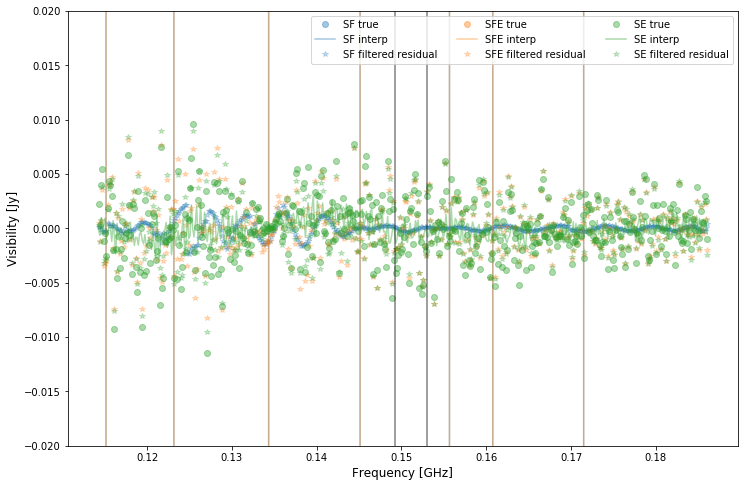

In [41]:
afreqs = v_uf['metadata']['freqs']
chans = get_good_channels(antpos[ai]-antpos[aj], freqs, *v_uf['metadata']['ubounds'])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlabel("Frequency [GHz]", fontsize=12)
ax.set_ylabel("Visibility [Jy]", fontsize=12)
ax.set_ylim(-0.02, 0.02)

# choose a baseline
#ai,aj = (16, 6) # Hits u=30 at 127 MHz
bl = v_uf['metadata']['baseline']
ai, aj = bl
bl_ns = sep * (antpos[ai] - antpos[aj])[0]
wgts = np.ones_like(afreqs)
filt_kwargs = {
    'filter_centers' : [0],
    'filter_half_widths' : [bl_ns / 2],
    'suppression_factors' : [1e-9],
    'mode' : 'dft_leastsq',
    'filter2d' : False,
    'fitting_options' : {'fundamental_period' : 1.5 * (afreqs[-1] - afreqs[0])},
}
for bm_fg, vmdl in v_uf.items():
    # the metadata has nothing to plot...
    if bm_fg == 'metadata' : continue
    # in case we want to isolate/exclude things
    #if bm_fg != 'SF': continue
    
    true_vis = vis[bm_fg[:2]][chans,ai,aj]
    # add in noise/eor if called for
    if len(bm_fg) == 3:
        true_vis += vis[bm_fg[0]+bm_fg[-1]][chans,ai,aj]
    true_vis = true_vis.flatten()

    vmdl = np.asarray(vmdl)
    vis_res = true_vis - vmdl
    if vmdl.size == 0: continue
    
    # filter the residuals to only have fourier components near the
    # geometric delay for the given baseline
    filt_vis_res = fourier_filter(afreqs, vis_res, wgts, **filt_kwargs)[0].flatten()
    filt_vis_res = vis_res - filt_vis_res
    
    ax.plot(afreqs, true_vis, ls='-', marker='o', lw=0, label=bm_fg+" true", alpha=0.4)
    cycle_colors(ax)
    # I think these labels are right?
    ax.plot(afreqs, vmdl, ls='-', label=bm_fg+" interp", alpha=0.4)
    cycle_colors(ax)
    #ax.plot(afreqs, vis_res, marker='x', lw=0, label=bm_fg+" residual", alpha=0.75)
    #cycle_colors(ax)
    ax.plot(afreqs, filt_vis_res, marker='*', lw=0, label=bm_fg+" filtered residual", alpha=0.25)
    
_ = ax.legend(ncol=3)

# for checking periodicity
f1, f2 = 0.14925, 0.153
for _f in (f1, f2):
    ax.axvline(_f, color='k', alpha=0.5)

Note that the very small spread in residuals around 135 MHz is where the 

In [60]:
all([freq in freqs for freq in afreqs])

True

In [42]:
df = f2 - f1
T = 1 / df # ns
T

266.66666666666646

In [43]:
bl = v_uf['metadata']['baseline']
bl_ns = sep * (antpos[bl[0]] - antpos[bl[1]])[0]
bl_ns

231.77697879057186

In [44]:
31.5 / bl_ns

0.13590650876704474

In [45]:
18.5 / bl_ns

0.07981810832350247

In [46]:
bl_freq = u / bl_ns
bl_dly = 1 / bl_freq
bl_dly

5.270747315329757

The upshot of the plot above seems to be that interpolation across baselines using a 40 ns low-pass filter preserves the EoR signal in the measurements, provided that sampling is dense enough.  Near the lower end of the band, it looks like the extrapolation from nearby baselines breaks down a bit and we don't see full foreground supression.  Above about 135 MHz, the sampling gets more dense (and the baseline in question closer to the middle of the range, I'd guess), and the residuals drop to a level comparable with the injected EoR signal, although at a spectral scale that is easier to differentiate.

In principle, at least, it is possible to use data from nearby baselines to subtract foregrounds from an individual baseline at a level deep enough to permit delay-spectrum analysis within the wedge.  However, there are hints that this might only work when sampling is dense enough that a line-of-sight (wedge-less) transform was possible anyway.  It is not clear if this will work if baseline samples are sparse.

At the very least, it seems likely that the frequency coverage of baselines around the $u$ of the baseline in question should be finer than the scale of foreground variation, which for this simulation is around 40 ns.  That would imply a minimum sampling scale of 25 MHz. However, we seem to see breakdowns when we have sampling density far above this (~100 samples per 100 MHz coming to about 1 MHz sampling density).  I'm not sure why, though it is likely that this could be improved by using delay filtering to allow interpolations at one frequency to inform the model at nearby frequencies.

In [47]:
# let's take a look at the delay transform of the foreground residuals
fg_mdl = np.asarray(v_uf["SF"])
fg_vis = np.asarray(vis["SF"][chans,ai,aj])
fg_res = fg_vis - fg_mdl

In [48]:
# for now, just use a fft
fg_res_dly = FFT(fg_res, 0)
dlys = fourier_freqs(fqs[chans])

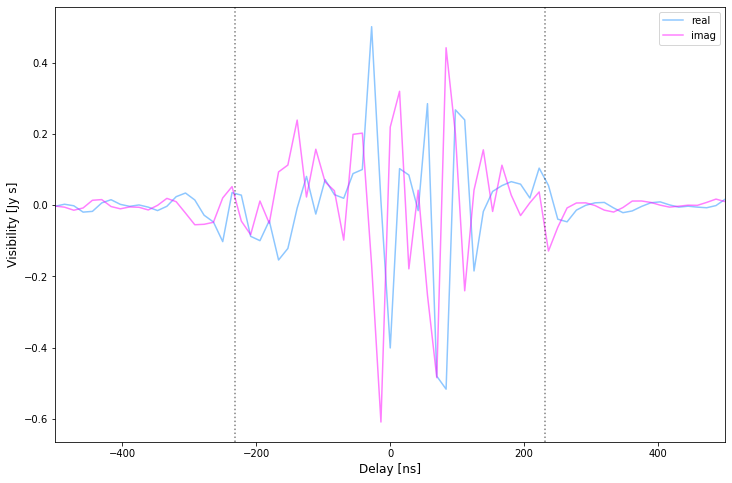

In [49]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlabel("Delay [ns]", fontsize=12)
ax.set_ylabel("Visibility [Jy s]", fontsize=12)
ax.set_xlim(-500,500)
ax.plot(dlys, fg_res_dly.real, color='dodgerblue', alpha=0.5, label='real')
ax.plot(dlys, fg_res_dly.imag, color='magenta', alpha=0.5, label='imag')
#ax.plot(dlys, fg_res_dly.real, lw=0, marker='o', color='dodgerblue', alpha=0.5, label="real")
#ax.plot(dlys, fg_res_dly.imag, lw=0, marker='x', color='magenta', alpha=0.5, label="imag")
ax.axvline(bl_ns, color='k', ls=':', alpha=0.5)
ax.axvline(-bl_ns, color='k', ls=':', alpha=0.5)
_ = ax.legend()

In [15]:
import numpy as np

In [50]:
# try filtering at ~200 ns?
wgts = np.ones_like(fg_res)
use_freqs = fqs[chans]
kwargs = {
    'filter_centers' : [0],
    'filter_half_widths' : [bl_ns / 4],
    'suppression_factors' : [1e-9],
    'mode' : 'dft_leastsq',
    'filter2d' : False,
    'fitting_options' : {'fundamental_period' : 1.5 * (use_freqs[-1] - use_freqs[0])},
}
filtered_fg_res = fourier_filter(use_freqs, fg_res, wgts, **kwargs)[0]

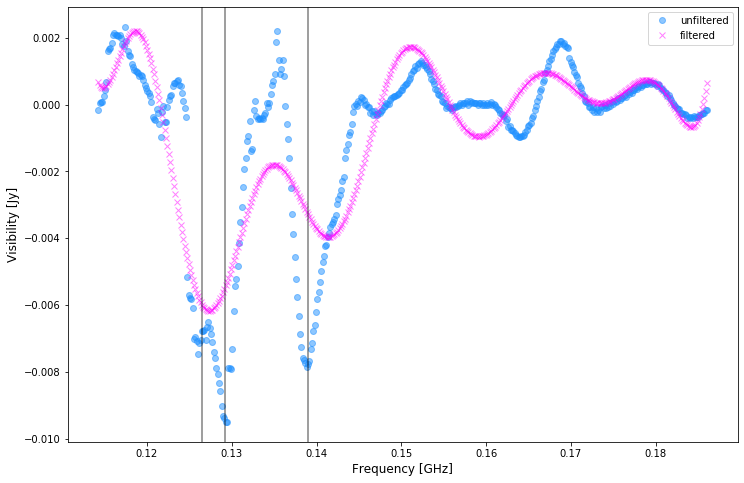

In [51]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlabel("Frequency [GHz]", fontsize=12)
ax.set_ylabel("Visibility [Jy]", fontsize=12)
ax.plot(use_freqs, fg_res, lw=0, marker='o', color='dodgerblue', alpha=0.5, label='unfiltered')
ax.plot(use_freqs, filtered_fg_res.flatten(), lw=0, marker='x', color='magenta', alpha=0.5, label='filtered')

#f1, f2 = 0.127, 0.1455
#for f in (f1, f2):
#    ax.axvline(f, color='k', alpha=0.7)
f_errs = (0.1265, 0.12925, 0.139)
for f in f_errs:
    ax.axvline(f, color='k', alpha=0.5)
_ = ax.legend()

In [52]:
u_errs = bl_ns * np.asarray(f_errs)
u_errs

array([29.31978782, 29.95717451, 32.21700005])

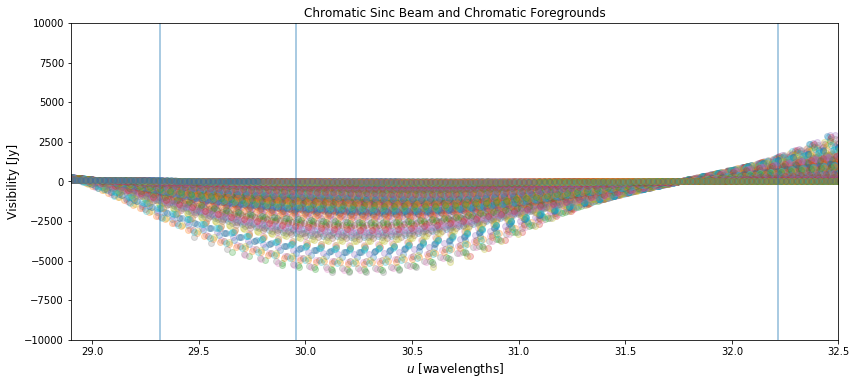

In [53]:
fqs = freqs.flatten()

fig = plt.figure(figsize=(12,10))
ax1 = fig.add_subplot(211)
ax1.set_title("Chromatic Sinc Beam and Chromatic Foregrounds", fontsize=12)

for ax in (ax1,):
    ax.set_xlabel(r"$u$ [wavelengths]", fontsize=12)
    ax.set_ylabel("Visibility [Jy]", fontsize=12)
    
for ai,aj in baselines:
    blx,bly,blz = bl = antpos[ai] - antpos[aj]
    us = blx * fqs
    ax1.plot(us, vis['SF'][:,ai,aj], marker='o', lw=0, alpha=0.25)
    
for u_ in u_errs:
    ax1.axvline(u_, alpha=0.5)
    ax2.axvline(u_)

ax1.set_ylim(-10000,10000)
ax1.set_xlim(28.9, 32.5)
plt.tight_layout()

In [54]:
bl_ns * 0.125

28.972122348821483

In [55]:
bl_ns * 0.129

29.89923026398377

In [56]:
bl_ns * 0.1325

30.710449689750774

In [57]:
bl_ns * 0.138

31.98522307309892

In [58]:
df = f2 - f1
T = 1/df
T

266.66666666666646

In [65]:
freqs

array([[0.06      , 0.0601564 , 0.06031281, ..., 0.21968719, 0.2198436 ,
        0.22      ]])

In [68]:
vis['GF'].shape

(1024, 27, 27)

In [73]:
ant1, ant2 = 2, 5
vij = vis['GF'][:,ant1, ant2]

In [74]:
myspline = interp1d(freqs.flatten(), vij, kind='cubic')

In [75]:
all([myspline(fq) == vij_ for fq, vij_ in zip(freqs.flatten(), vij)])

False

In [ ]:
# plot the above in delay space (what's up with the structure in foreground residuals?)
# is ^ related to the horizon?
# redo the above with less complete sampling
# why do we do better at some frequencies than others?

In [ ]:
# as a simple approach, maybe try downsampling the data before filtering?
# some notes: freqs cover 60 MHz to 220 MHz with 1024 channels
# this comes to a channel width of ~ 156 kHz
# as a first pass, let's downsample to a resolution of ~ 1 MHz

In [ ]:
from scipy import stats

In [ ]:
stats.binned_statistic?

In [ ]:
# quick test of using binned_statistic to downsample
test_vis = np.asarray(v_uf['SF'])
# construct new frequency channels
new_freqs = np.arange(afreqs.min(), afreqs.max(), 1e-3)
new_vis = np.asarray(
    stats.binned_statistic(afreqs, test_vis.real, statistic='median', bins=new_freqs)[0]
).astype(np.complex)
new_vis += 1j*np.asarray(
    stats.binned_statistic(afreqs, test_vis.imag, statistic='median', bins=new_freqs)[0]
)

In [ ]:
# now compare on a plot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.set_xlabel('Frequency [GHz]', fontsize=12)
ax.set_ylabel('Visibility [Jy]', fontsize=12)

use_freqs = 0.5*(new_freqs[1:] + new_freqs[:-1])
ax.plot(afreqs, test_vis.real, color='k', marker='o', ms=2, alpha=0.7, label="Original")
ax.plot(use_freqs, new_vis.real, color='darkorange', marker='*', alpha=0.7, label="Downsampled")
_ = ax.legend()

## Impose a bandpass on ideal simulated visibilities.

I think the next step is to build a linear solver for calibrating the bandpass to ensure that different baselines accessing the same $u$ mode have been calibrated to one another.  Based on the results above, linear interpolation is probably not sufficient.  We need to write down equations of the form:
\begin{equation}
V(\vec b, \nu) = \beta_\nu V(u)
\end{equation}
But given that V(u) is not the same at every frequency, we want the $\beta_\nu$ answers that produce the smoothest result.

In [ ]:
#bandpass = np.polyval([-8, 4, -.75, 1], freqs)
bandpass = np.ones_like(freqs)
bandpass /= np.average(bandpass)
#plt.figure()
#plt.plot(freqs,bandpass)
#plt.show()

# Solving interpolating in $V$ and $g$

Looping over all (non-redundant) baselines, looping over discrete $u_k$ modes,
interpolate each $g(\nu)\cdot V_{ij}(\nu)$ to the exact frequency where $\nu = u_k / b$, so that the
baseline samples that $u_k$ mode exactly.

Set up a system of equations that discretely samples $g(\nu_i)$ and models the bandpass at $\nu$ as a linear interpolation of adjacent discrete samples of the bandpass, e.g.:
\begin{equation}
g(\nu)= f\cdot g(\nu_i) + (1-f)\cdot g(\nu_{i+1})
\end{equation}
for $f = (\nu_{i+1}-\nu)/\Delta\nu$.

## Generate System of Equations

In [ ]:
#us = np.linspace(0, 1150, 2300)
#FQ_RES = freqs[1] - freqs[0]
#data = {}
#for ai,aj in baselines:
#    blx,bly,blz = bl = antpos[ai] - antpos[aj]
#    for k,u0 in enumerate(us):
#        fq = u0 / blx
#        if fq < freqs[0] or fq >= freqs[-1]: continue
#        fq_px0 = np.floor((fq - freqs[0]) / FQ_RES).astype(np.int)
#        fq_px1 = fq_px0 + 1
#        d = (fq - freqs[0]) / FQ_RES - fq_px0
#        cubic = scipy.interpolate.interp1d(freqs, bandpass * vis[:,ai,aj], kind='cubic', assume_sorted=True)
#        v = cubic(fq)
#        data['%f * g_%d * u_%d + %f * g_%d * u_%d' % (1-d, fq_px0, k, d, fq_px1, k)] = v

## Solve System of Equations (compute intense)

In [ ]:
#sol0 = {'g_%d' % (i): 1. for i in range(freqs.size)}
#sol0.update({'u_%d' % (i): (20+0j) for i in range(us.size)})
#ls = linsolve.LinProductSolver(data, sol0=sol0)
#meta, sol = ls.solve_iteratively(conv_crit=1e-14, maxiter=500, verbose=True)

In [ ]:
#print meta['conv_crit'], meta['iter'], meta['chisq']

## Compare, for a particular $u$, the data vs. model solution

In [ ]:
#plt.figure()
#keys = [k for k in data.keys() if k.find('u_600 ') != -1]
#keys.sort(key=lambda k: int(k.split()[2][2:]))
#plt.plot([data[k] for k in keys], '.-')
#plt.plot([eval(k,sol) for k in keys], '.-')
#plt.show()

## Extract the Bandpass and $u$-modes as arrays

In [ ]:
#px = np.array([int(k[2:]) for k in sol.keys() if k.startswith('u')])
#usol = np.zeros(us.shape, dtype=np.complex64)
#usol[px] = [sol[k] for k in sol.keys() if k.startswith('u')]
#px = np.array([int(k[2:]) for k in sol.keys() if k.startswith('g')])
#bpsol = np.zeros(freqs.size, dtype=np.complex64)
#bpsol[px] = [sol[k] for k in sol.keys() if k.startswith('g')]
#bpavg = np.average(bpsol)
## Set average bandpass to 1, solving a degeneracy between u and g
#bpsol /= bpavg
#usol *= bpavg

## Plot (true) visibilities and solution, plot unsmooth structure on bandpass

In [ ]:
#plt.figure(figsize=(8,4))
#plt.subplot(121)
#for sep in baselines:
#    i,j = seps[sep]
#    u = (antpos[j][0] - antpos[i][0]) * freqs
#    plt.plot(u, vis[:,i,j], '.')
#plt.plot(us,usol)
#plt.subplot(122)
#p = np.polyfit(np.log10(freqs), np.log10(bpsol), deg=1)
#pbp = 10**np.polyval(p, np.log10(freqs))
#plt.plot(freqs, bpsol/pbp)
##plt.plot(freqs, bpsol)
##plt.plot(freqs, bandpass)
#plt.show()

In [ ]:
#URES = us[1] - us[0]
#plt.figure()
#for sep in baselines:
#    ai,aj = seps[sep]
#    b = (antpos[aj][0] - antpos[ai][0])
#    u = b * freqs
#    u_px0 = np.floor(u / URES).astype(np.int)
#    ind = u_px0 < 2280
#    u_px0 = u_px0[ind]
#    u_px1 = u_px0 + 1
#    f = u[ind]/URES - u_px0
#    #f = np.where(usol[u_px0] == 0, 1, f)
#    #f = np.where(usol[u_px1] == 0, 0, f)
#    umdl = (1-f) * usol[u_px0] + f * usol[u_px1]
#    #plt.plot(u, bandpass * vis[:,0,i], '.')
#    #plt.plot(u, bpsol * umdl, '.')
#    plt.plot(u[ind], bandpass[ind] * vis[:,ai,aj][ind] - bpsol[ind] * umdl, '.')
#plt.plot(us,usol/1000)
#plt.show()

In [ ]:
#plt.figure()
#u = 300.
#FQ_RES = freqs[1] - freqs[0]
#for sep in baselines:
#    i,j = seps[sep]
#    b = (antpos[j][0] - antpos[i][0])
#    fq = u / b
#    if fq < freqs[0] or fq > freqs[-1]: continue
#    cubic = scipy.interpolate.interp1d(freqs, vis[:,i,j], kind='cubic', assume_sorted=True)
#    fq_px0 = np.floor((fq - freqs[0]) / FQ_RES).astype(np.int)
#    fq_px1 = fq_px0 + 1
#    d = (fq - freqs[0]) / FQ_RES - fq_px0
#    v0 = (1-d) * vis[fq_px0,i,j] + d * vis[fq_px1,i,j]
#    #plt.plot([fq], v0 / 10**(np.polyval(p, fq)), 'r.')
#    plt.plot([fq], cubic(fq), 'r.')
#    plt.plot([fq], cubic(fq) / 10**(np.polyval(p, np.log10(fq))), 'b.')
#plt.show()

In [ ]:
#u = 300.
#FQ_RES = freqs[1] - freqs[0]
#fq_list, V_list = [], []
#for sep in baselines:
#    i,j = seps[sep]
#    b = (antpos[j][0] - antpos[i][0])
#    fq = u / b
#    if fq < freqs[0] or fq > freqs[-1]: continue
#    cubic = scipy.interpolate.interp1d(freqs, vis[:,i,j], kind='cubic', assume_sorted=True)
#    fq_list.append(fq)
#    V_list.append(cubic(fq))
#fq_list = np.array(fq_list)
#V_list = np.array(V_list)
#plt.figure()
#plt.plot(fq_list, V_list, 'k.-')